In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import math as M
from copy import deepcopy

serie_id = 2

r_moy = [0.045, 0.040][serie_id-1] # m
delta_r_moy = 0.001 # m
delta_U = 0.5 # V
delta_I = 0.005 # A
mu0 = 1.25663706212e-6
n = 130
R = 0.15

df = pd.read_csv(f"serie{serie_id}.csv")
df

,U,I
0,134,1.03
1,161,1.18
2,189,1.31
3,282,1.65
4,298,1.66


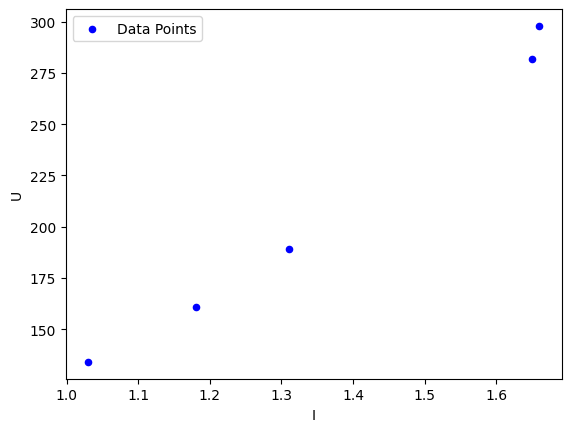

In [2]:
df.plot(x='I', y='U', kind='scatter', color='blue', marker='o', label='Data Points')

plt.show()

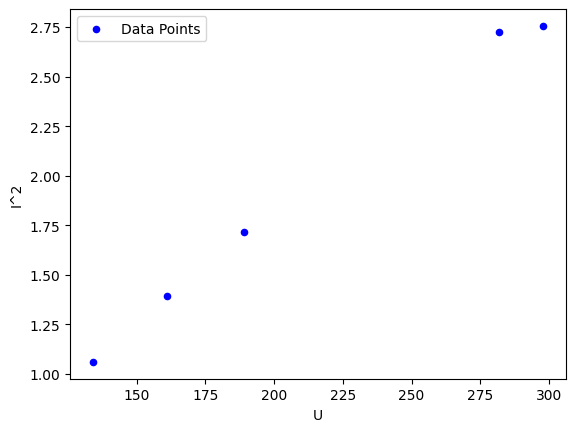

In [3]:
df["I^2"] = df.apply(lambda row:
    row["I"]**2, axis = 1)
df.plot(x='U', y='I^2', kind='scatter', color='blue', marker='o', label='Data Points')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


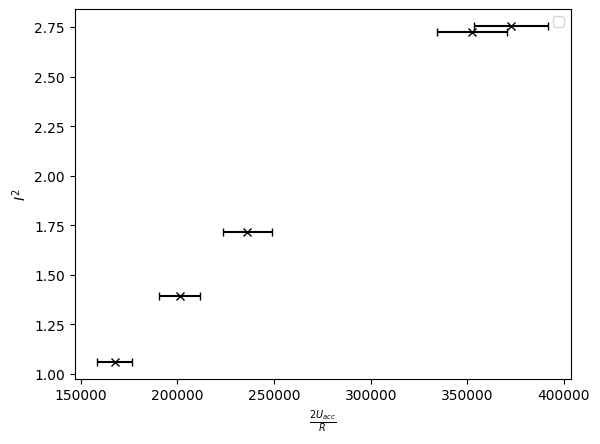

In [4]:
df["2U/R^2"] = df["U"] / r_moy**2 * 2
df["delta(2U/R^2)"] = df.apply(lambda row:
    2 / r_moy**2 * delta_U + 4 * row["U"] / r_moy**3 * delta_r_moy, 
    axis = 1)
df["delta(U)"] = [delta_U] * len(df['I^2'])
df["delta(I)"] = [delta_I] * len(df['I^2'])
df["delta(I^2)"] = df.apply(lambda row:
    2 * row["I"] * row["delta(I)"], 
    axis = 1)

plt.errorbar(df["2U/R^2"], df["I^2"], xerr=df["delta(2U/R^2)"],
             color='black', marker='x', linestyle='None', capsize=3)

# Set plot labels and title
plt.xlabel(r'$\frac{2U_{acc}}{R}$')
plt.ylabel(r"$I^2$")
# titre sur latex
# plt.title(r"rapport des tensions en fonction de $log_{10}(RC)$")
plt.legend()
plt.show()

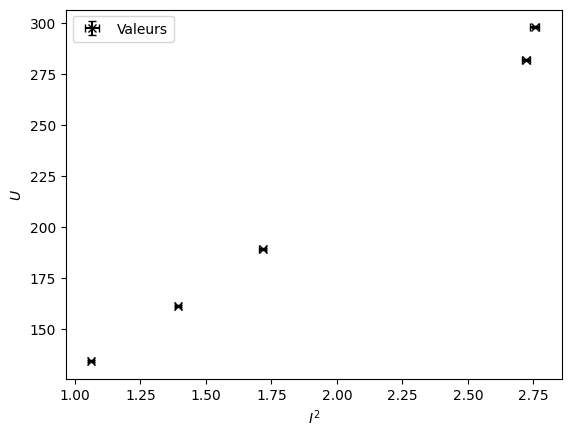

In [5]:
plt.errorbar(df["I^2"], df["U"], xerr=df["delta(I^2)"], yerr=df["delta(U)"],
             color='black', marker='x', linestyle='None', label="Valeurs", capsize=3)

# Set plot labels and title
plt.xlabel(r'$I^2$')
plt.ylabel(r"$U$")
# titre sur latex
# plt.title(r"rapport des tensions en fonction de $log_{10}(RC)$")
plt.legend()
# plt.savefig('U_en_fc_I2.eps')
plt.show()

In [6]:
df

,U,I,I^2,2U/R^2,delta(2U/R^2),delta(U),delta(I),delta(I^2)
0,134,1.03,1.0609,167500.0,9000.0,0.5,0.005,0.0103
1,161,1.18,1.3924,201250.0,10687.5,0.5,0.005,0.0118
2,189,1.31,1.7161,236250.0,12437.5,0.5,0.005,0.0131
3,282,1.65,2.7225,352500.0,18250.0,0.5,0.005,0.0165
4,298,1.66,2.7556,372500.0,19250.0,0.5,0.005,0.0166


C:\Users\bgolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            WLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     589.6
Date:                Mon, 08 Jan 2024   Prob (F-statistic):           0.000153
Time:                        20:58:16   Log-Likelihood:                -14.797
No. Observations:                   5   AIC:                             33.59
Df Residuals:                       3   BIC:                             32.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.6012      7.973      3.838      0.0

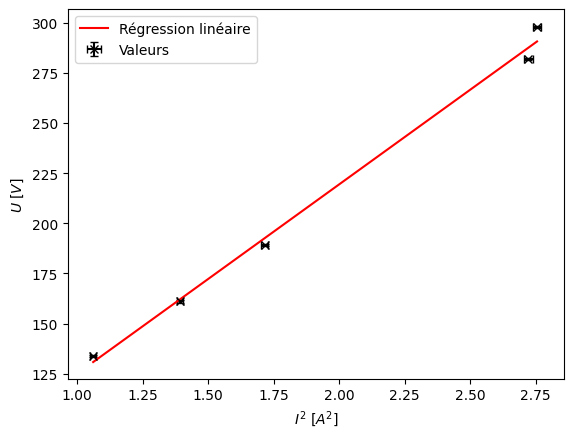

In [7]:
df["delta(U)"] = [delta_U] * len(df['U'])

X = df['I^2'].values
Y = df['U'].values
X_uncertainty = df['delta(I^2)'].values
Y_uncertainty = df['delta(U)'].values

X_with_intercept = sm.add_constant(X)  # Add a constant term (intercept) to the X values

# Weighted least squares regression
model = sm.WLS(Y, X_with_intercept, weights=1 / Y_uncertainty**2)
results = model.fit()

# Print the regression summary
print(results.summary())

slope = results.params[1]
intercept = results.params[0]

standard_errors = results.bse

# The standard error for the slope (coefficient of X) is typically the second element in the standard_errors array
slope_standard_error = standard_errors[1]

print("Slope: ", slope)
print("Standard Error of the Slope:", slope_standard_error)
print("e/m: ", slope * R**2 * (5/4)**3 / r_moy**2 / mu0**2 / n**2 * 2)

predicted_Y = results.predict(X_with_intercept)
plt.errorbar(X, Y, xerr=X_uncertainty, yerr=Y_uncertainty, #est négligeable
          color='black', marker='x', linestyle='None', label="Valeurs", capsize=3)
plt.plot(X, predicted_Y, color='red', label='Régression linéaire')

# Set plot labels and title
plt.xlabel(r"$I^2$ [$A^2$]")
plt.ylabel(r'$U$ [$V$]')
# titre sur latex
# plt.title(r"qqch")
plt.legend()
plt.savefig(f's{serie_id}_U_from_I_sq.eps')
plt.show()

In [8]:
latex_code1 = df.to_latex(index=True, escape=False, 
    columns = ["U", "I", "I^2"], formatters={
    "I" : (lambda v: f'{v:1.2f}'),
    "I^2" : (lambda v: f'{v:1.2f}'),
    })
print(latex_code1)

\begin{tabular}{lrrr}
\toprule
 & U & I & I^2 \\
\midrule
0 & 134 & 1.03 & 1.06 \\
1 & 161 & 1.18 & 1.39 \\
2 & 189 & 1.31 & 1.72 \\
3 & 282 & 1.65 & 2.72 \\
4 & 298 & 1.66 & 2.76 \\
\bottomrule
\end{tabular}

